# Analysis of Student School Association Performance Testing

For test executions run in April, 2025.

## Introduction

This notebook provides basic summary statistics and boxplot charts for comparing the runtime for four tests performed with the code in this repository:

1. Load of _n_ Students and Student School Associations.
2. Reading all _n_ Students by URL (`/ed-fi/students/xyz`, from the `Location` header returned in test one).
3. Reading all _n_ Students by query (`/ed-fi/students?studentUniqueId=x`).
4. Reading all _n_ Students with page size 500.

## Methodology

The data were generated from test runs of 9,999 students, completed on a local developer machine running both the ODS/API 7.1 and the Data Management Service (snapshot from April 11) in Docker Desktop on Windows 11. The developer machine has 32 GB of memory and an Intel vPro i7 16-core processor.

Tests were orchestrated by PowerShell scripts for each platform. These scripts setup the basics necessary for running the four tests; for example, ensuring that the right credentials are available and that a school is available. The two PowerShell scripts then call out to a Python script that performs the four tests with identical code for each application. This Python script uses async / await for high performance I/O.

The Docker containers and their volumes were deleted after each test run, so that the next test run would start with the same clean slate.

In [113]:
# Import necessary libraries
import pandas as pd
from plotnine import ggplot, aes, geom_boxplot, labs, coord_flip, theme_bw
from IPython.display import display

# Load the CSV data into a DataFrame
data = pd.read_csv("performance.csv")

## Results

### Summary Statistics for ODS/API

In [114]:
data[data.system == "ods"].describe()

,studentCount,studentCreationTime,getByIdTime,getByQueryTime,getAllTime
count,5.0,5.000000,5.000000,5.000000,5.000000
mean,9999.0,1281.343427,96.626226,112.431649,1.662718
std,0.0,83.778879,40.314897,48.096160,0.642267
min,9999.0,1215.561947,60.594246,71.687299,1.076826
25%,9999.0,1225.172885,66.058507,75.876506,1.270527
50%,9999.0,1231.108213,78.241482,84.952404,1.281375
75%,9999.0,1327.153857,126.483218,162.353164,2.138094
max,9999.0,1407.720233,151.753677,167.288874,2.546766


### Summary Statistics for DMS

In [115]:
data[data.system == "dms"].describe()

,studentCount,studentCreationTime,getByIdTime,getByQueryTime,getAllTime
count,5.0,5.000000,5.000000,5.000000,5.000000
mean,9999.0,258.618283,79.648694,60.154300,0.489477
std,0.0,88.452517,19.950843,17.996982,0.114316
min,9999.0,199.614714,62.383897,48.363851,0.367977
25%,9999.0,211.196290,71.064204,49.309747,0.444016
50%,9999.0,216.189445,73.844181,53.262165,0.478855
75%,9999.0,253.402209,76.959330,58.251750,0.479365
max,9999.0,412.688756,113.991857,91.583988,0.677171


### Student Creation Time

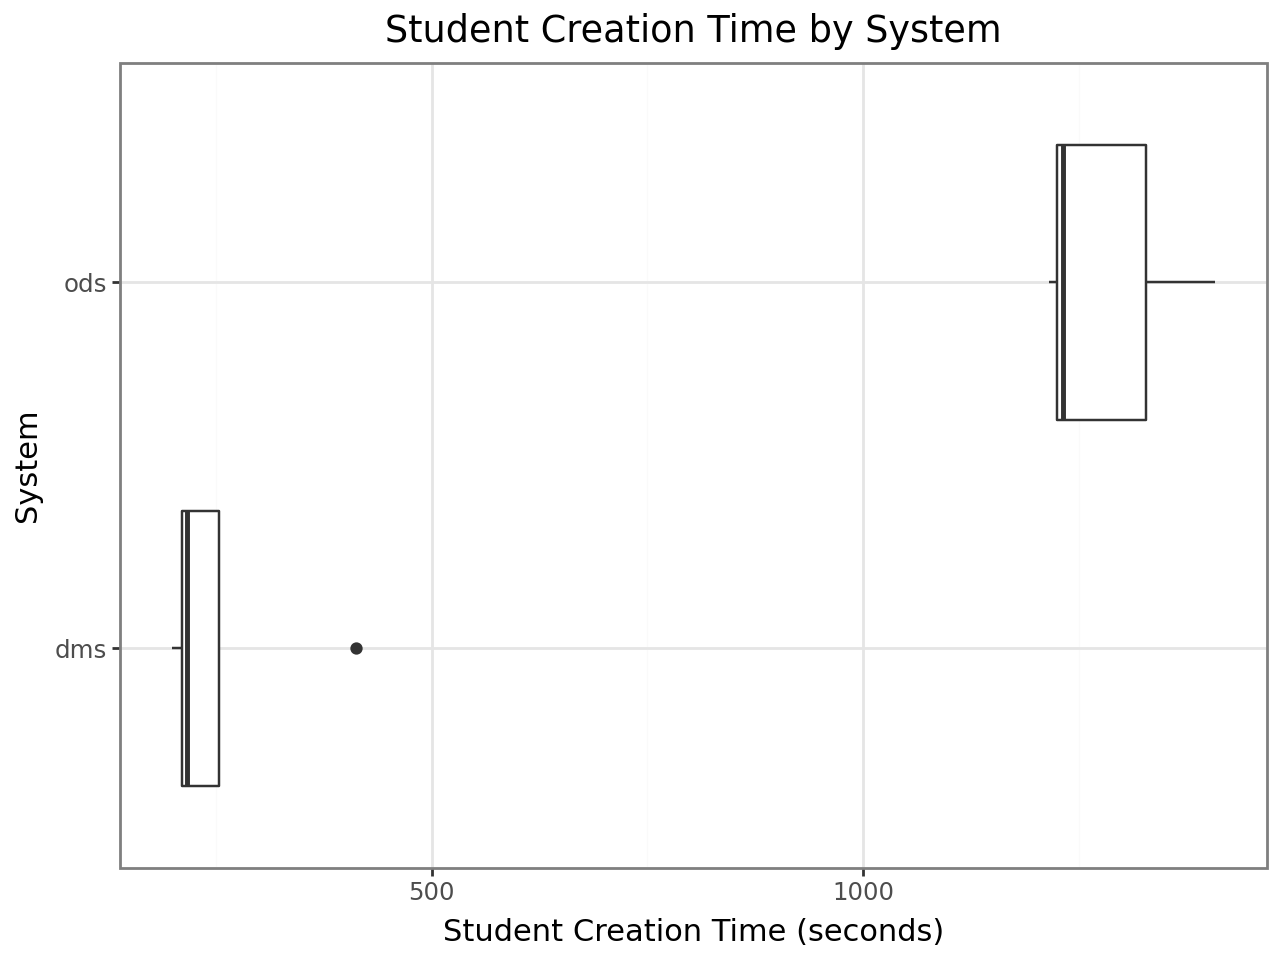

In [116]:
# Plot 1: studentCreationTime
plot1 = (
    ggplot(data)
    + geom_boxplot(aes(x="factor(system)", y="studentCreationTime"))
    + coord_flip()
    + labs(
        title="Student Creation Time by System",
        y="Student Creation Time (seconds)",
        x="System"
    )
    + theme_bw()
)
display(plot1)

### Get By ID

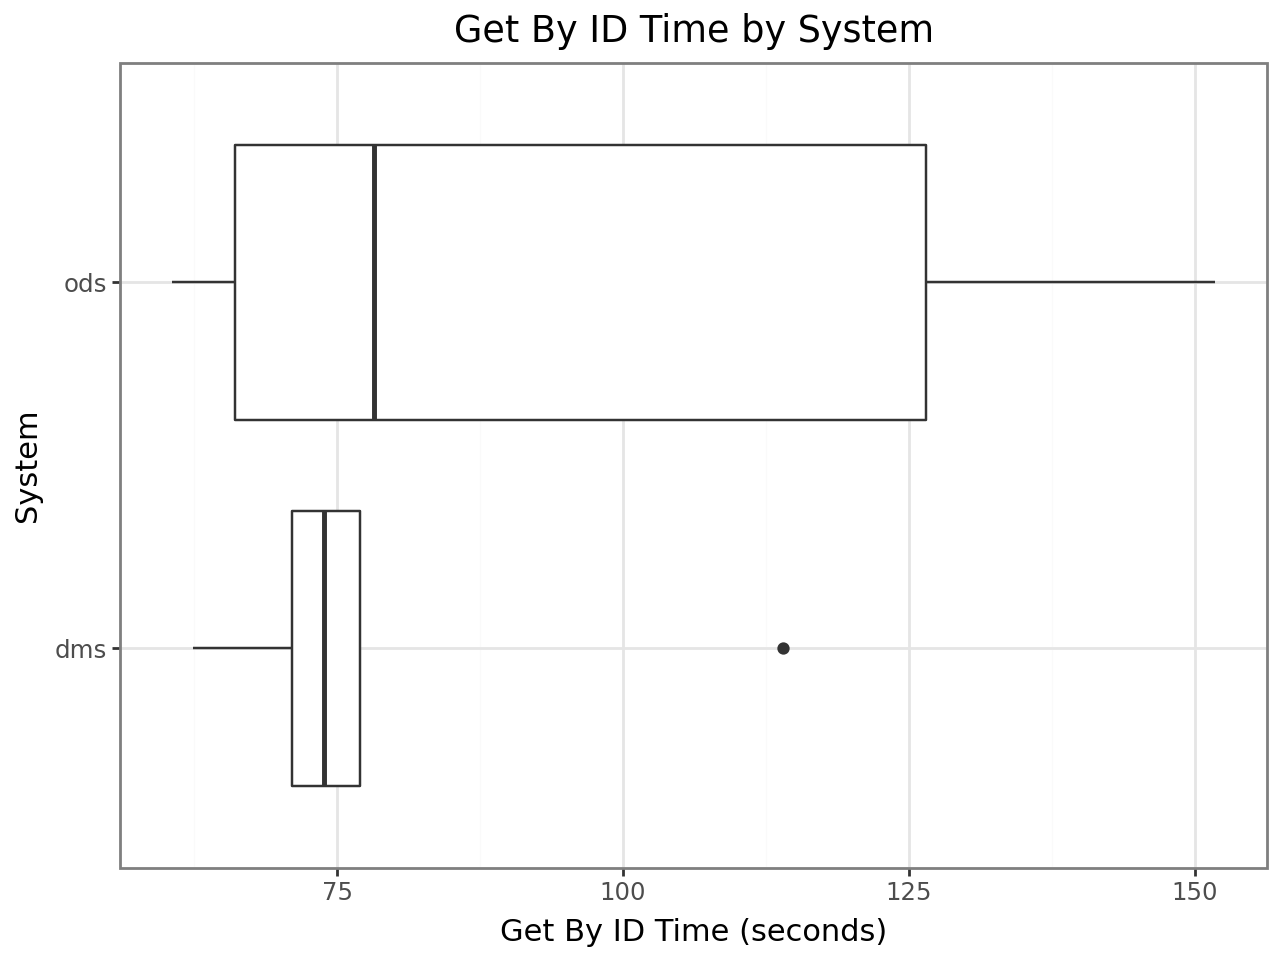

In [117]:
# Plot 2: getByIdTime
plot2 = (
    ggplot(data)
    + geom_boxplot(aes(x="factor(system)", y="getByIdTime"))
    + coord_flip()
    + labs(
        title="Get By ID Time by System",
        x="System",
        y="Get By ID Time (seconds)"
    )
    + theme_bw()
)
display(plot2)

### Get By Query (Student Unique ID)

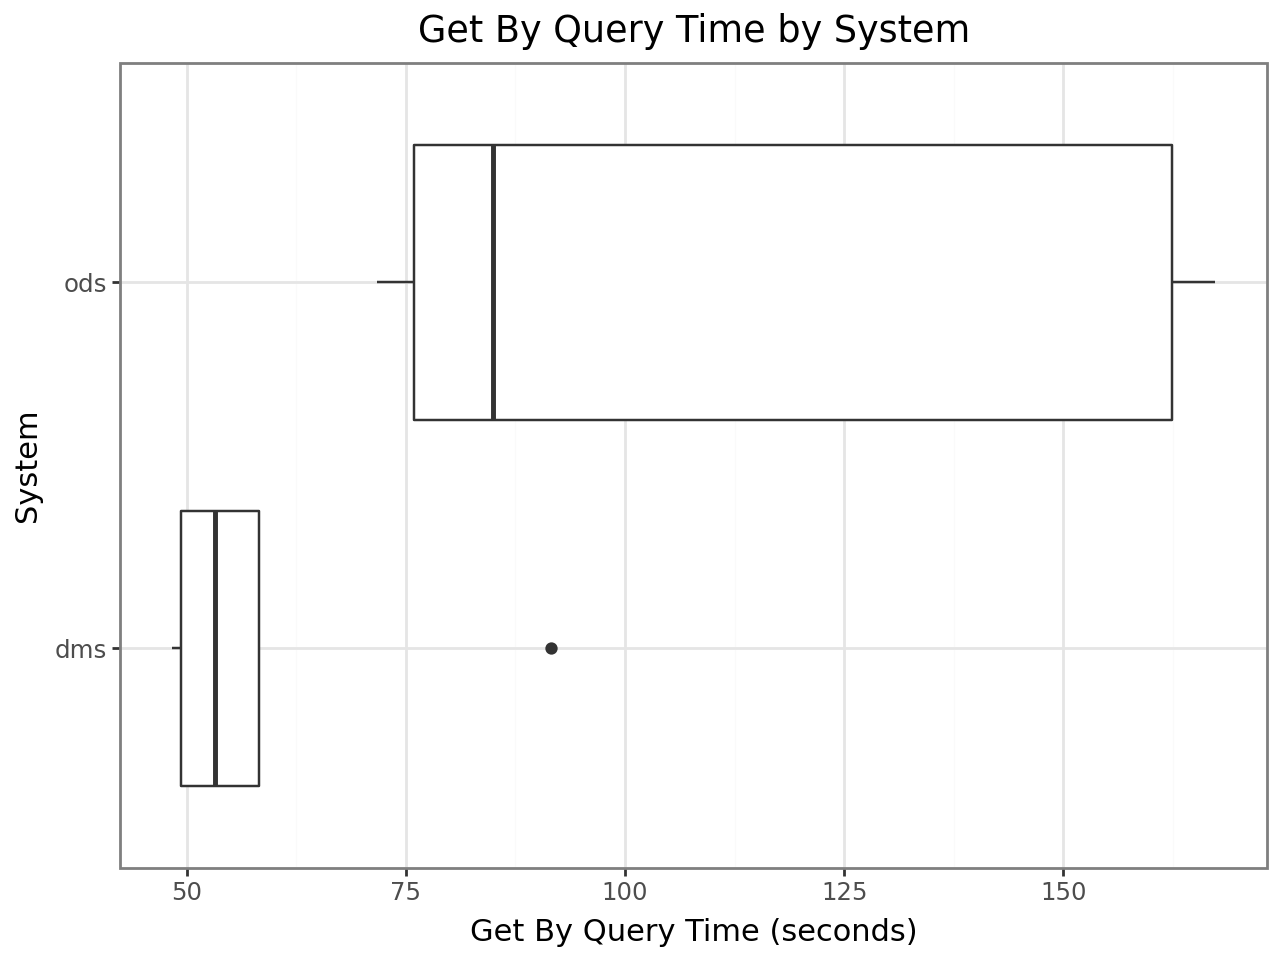

In [118]:
# Plot 3: getByQueryTime
plot3 = (
    ggplot(data)
    + geom_boxplot(aes(x="factor(system)", y="getByQueryTime"))
    + coord_flip()
    + labs(
        title="Get By Query Time by System",
        x="System",
        y="Get By Query Time (seconds)"
    )
    + theme_bw()
)
display(plot3)

### Get All

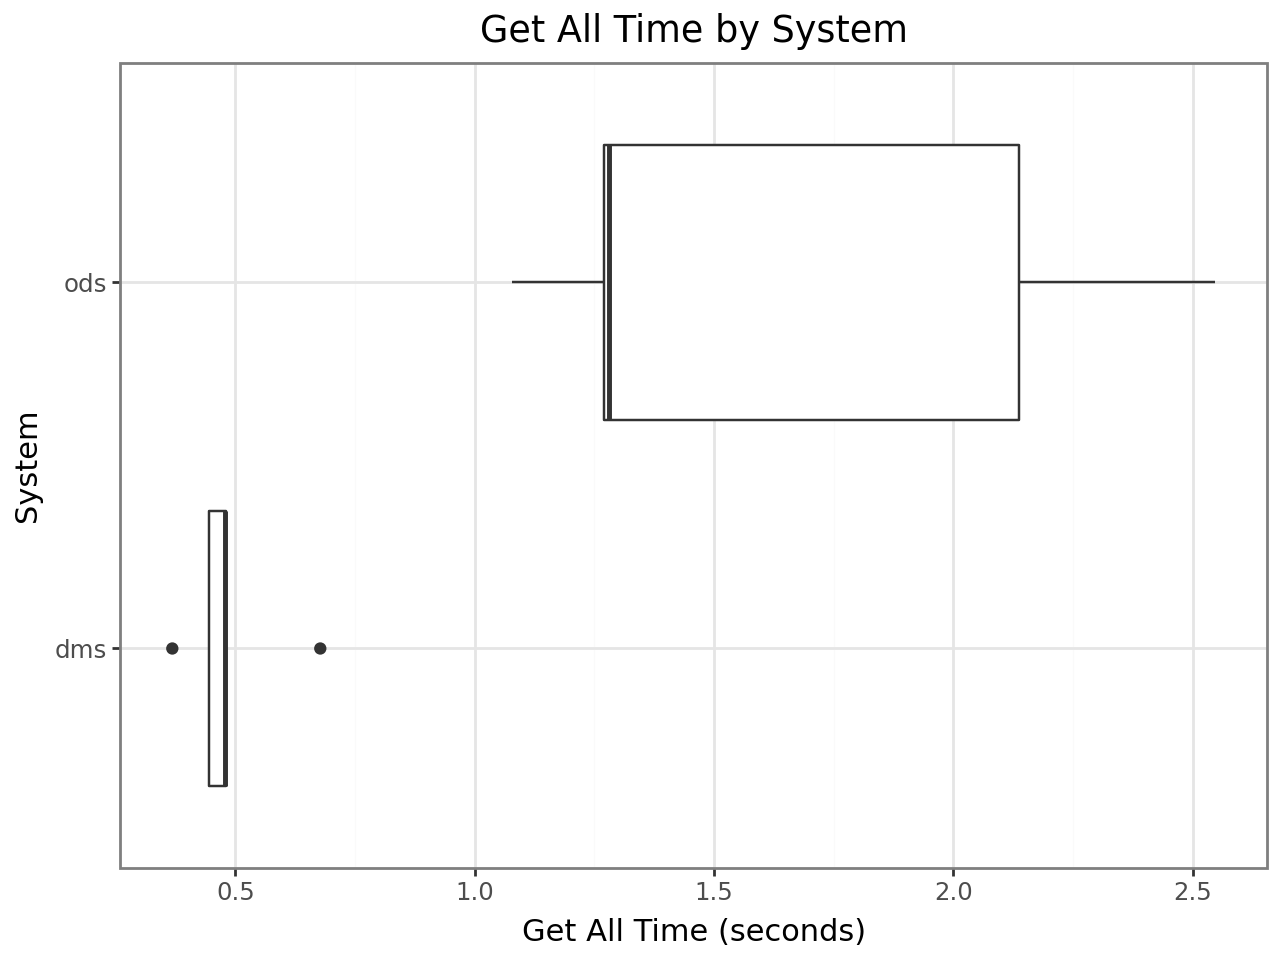

In [119]:
# Plot 4: getAllTime
plot4 = (
    ggplot(data)
    + geom_boxplot(aes(x="factor(system)", y="getAllTime"))
    + coord_flip()
    + labs(
        title="Get All Time by System",
        x="System",
        y="Get All Time (seconds)"
    )
    + theme_bw()
)
display(plot4)

### CPU and Memory Usage by Container

In [120]:
import json

# Read JSONL file
stats_data = []
with open("performance_stats.jsonl", "r") as f:
    for line in f:
        o = json.loads(line)
        stats_data.append(o)

perf_stats = pd.DataFrame(stats_data)

In [121]:
# Data wrangling
perf_stats["CPU"] = perf_stats.CPUPerc.str.replace("%", "").astype("float")
perf_stats["Mem"] = perf_stats.MemPerc.str.replace("%", "").astype("float")
perf_stats["MemUsageRaw"] = perf_stats.MemUsage.copy()
perf_stats["MemUsage"] = perf_stats.MemUsageRaw.str.extract("^([\d+\.]+)").astype("float")
perf_stats["MemUsageUnits"] = perf_stats.MemUsageRaw.str.extract("^[\d+\.]+(\w)")
perf_stats["MemUsage"] = perf_stats.apply(lambda row: row.MemUsage if row.MemUsageUnits == "M" else row.MemUsage * 1024, axis=1)


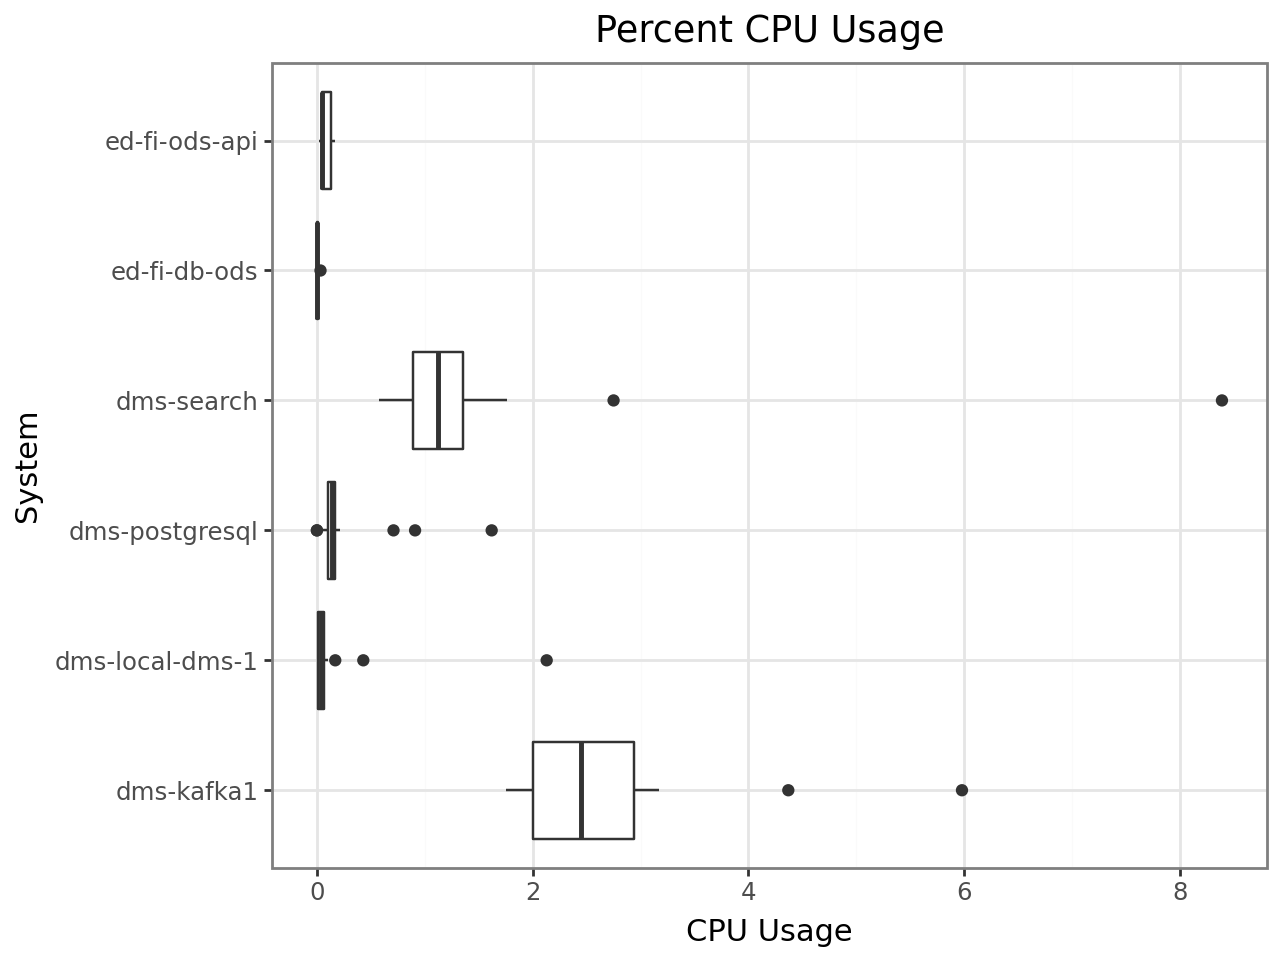

In [122]:
# Plot 5: CPU %
plot5 = (
    ggplot(perf_stats)
    + geom_boxplot(aes(x="factor(Container)", y="CPU"))
    + coord_flip()
    + labs(
        title="Percent CPU Usage",
        x="System",
        y="CPU Usage"
    )
    + theme_bw()
)
display(plot5)

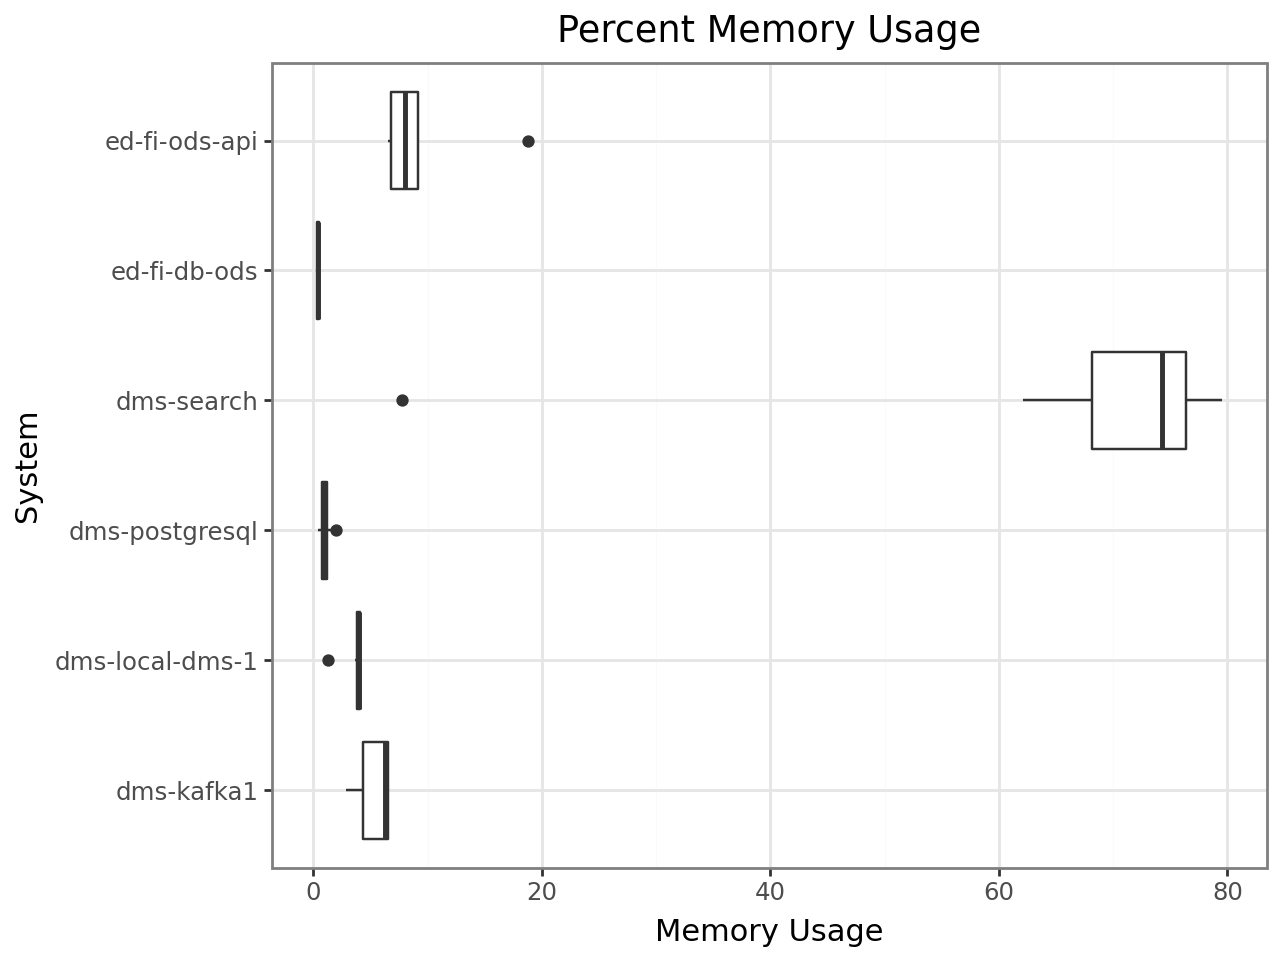

In [123]:
# Plot 6: Memory %
plot6 = (
    ggplot(perf_stats)
    + geom_boxplot(aes(x="factor(Container)", y="Mem"))
    + coord_flip()
    + labs(
        title="Percent Memory Usage",
        x="System",
        y="Memory Usage"
    )
    + theme_bw()
)
display(plot6)

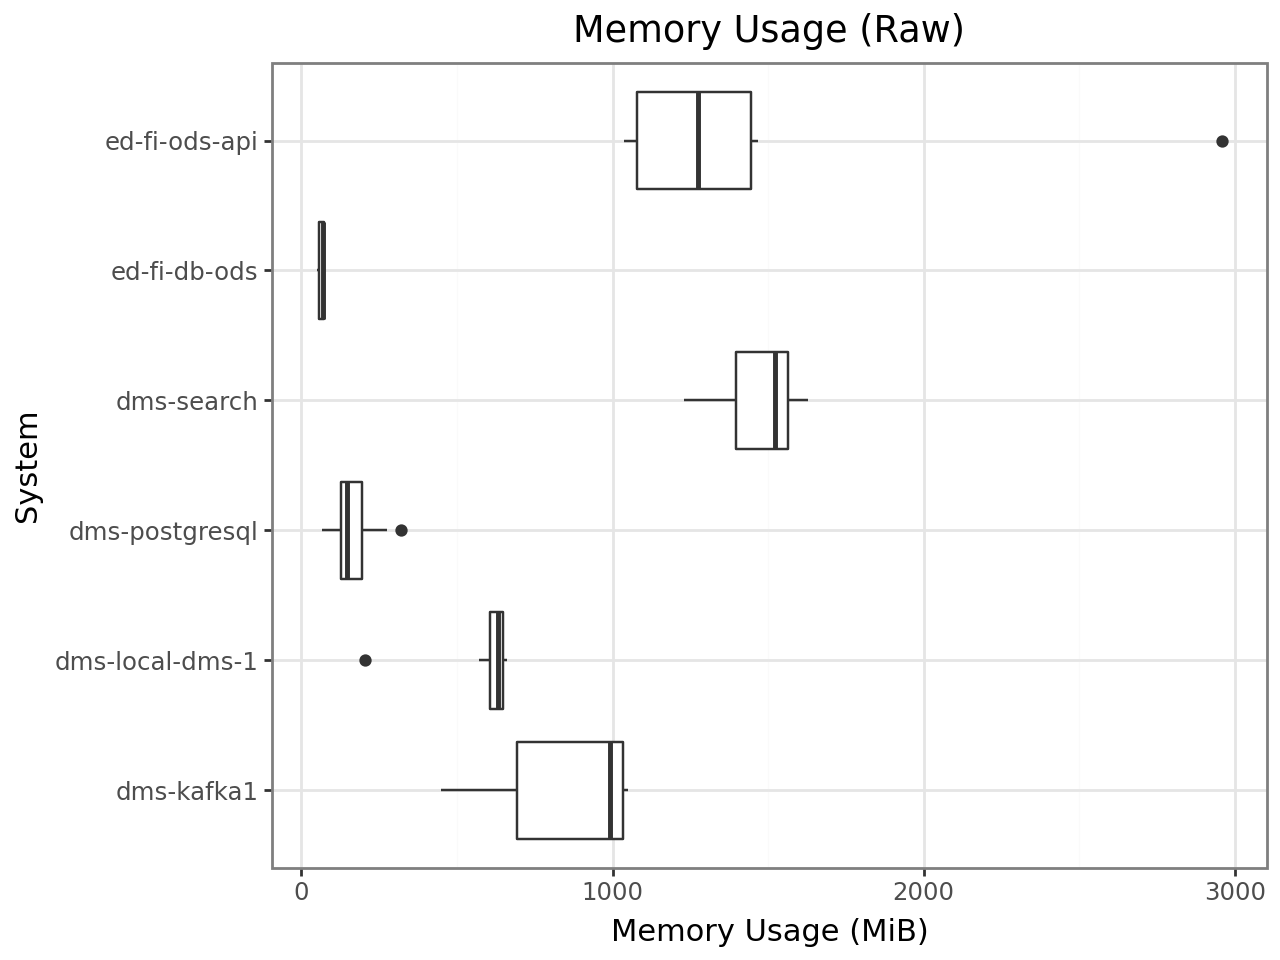

In [124]:
# Plot 7: Memory Raw
plot7= (
    ggplot(perf_stats)
    + geom_boxplot(aes(x="factor(Container)", y="MemUsage"))
    + coord_flip()
    + labs(
        title="Memory Usage (Raw)",
        x="System",
        y="Memory Usage (MiB)"
    )
    + theme_bw()
)
display(plot7)

In [106]:
# with pd.option_context("display.max_rows", None):
#  display(perf_stats[["MemUsage", "MemUsageRaw"]])

## Analysis

### Performance Comparison

The most striking result is to see the average insert time cut by 80% when switching from the ODS/API to the DMS. The retrieval times are also much better, with both lower averages and lower spread as seen visually in the box plots.

The "lab" conditions for this test, as performed in the days leading up to the Ed-Fi Tech Congress 2025, were not ideal, and 5 executions do not provide sufficient evidence for tests of statistical significance. That being the case, the results appear convincing: at this time, the DMS code is completing its tasks faster than the ODS/API code.

It is important to recognize that the DMS codebase is not complete, and this analysis will need to be repeated from time to time as the features move toward a production release.

### Resource Consumption

One reason for the improved performance is that the DMS is currently separating the database load onto two different servers, with Kafka sitting between them to mediate the replication. This comes at a cost, as seen here in resource usage.

CPU usage for the core API applications is very similar, but the ODS/API web application is using significantly more memory than the API application. This suggests that the web server container should consume fewer resources and, depending on system architecture, cost less to operate.

The memory usage of OpenSearch looks concerning. It is far out of proportion compared to PostgreSQL in support of the ODS/API, raising an important question about the real-world cost of running this server.

## Next Steps

Next steps could include:

1. Running these tests in a more pristine lab environment, on a system that does not have anti-virus, Slack, open presentations, etc.
2. Executing the tests more times for rigorous statistical analysis; ideally 30 times each, or use bootstrapping if fewer.
3. Running with larger student counts. Watching the OpenSearch memory and CPU with larger loads would be interesting: does resource consumption continue to go up in a linear (or worse) fashion? Is the high load a baseline that has room for larger data sets without much impact? 
4. Use ODS/API 7.3 instead of 7.1.
5. Try the serialized data feature in ODS/API 7.3.